# TEXT SUMMARIZATION

# Problem Statement

Customer reviews can be lengthy and detailed. Manually analysing these reviews, as you might guess, takes a long time. This is where Natural Language Processing's application can be put to use to develop a short summary for lengthy reviews.

Our objective here is to generate a summary for the **"Amazon Fine Food reviews"** using the **abstraction-based** and as well as **extraction-based** text summarization approaches.

# Project pipeline

1. Understanding Text Summarization
2. Text pre-processing
3. Abstractive Text Summarization using LSTM, ENCODER-DECODER architecture
4. Extractive Text Summarization using Transformer

## 1. Understanding Text Summarization

**Text summarization** is a Natural Language Processing application which produces short and meaningful summary of a lengthy paragraph thereby helping us to understand the essence of the topic in an efficient way.

**Types of Text Summarization**

1. Abstrative Based (With attension and without attension)
2. Extractive Based (Transformer)



In Abstractive based, we generate new sentences from the original text. The sentences generated through abstractive summarization might not be present in the original text.

In Extractive based, we identify the important sentences or phrases from the original text and extract only those from the text. Those extracted sentences would be our summary.

Custom Attention Layer: Keras does not officially support attention layer. We will use a third-party implementation.

## Import the Libraries

In [4]:
pip install keras-self-attention

  Using cached keras-self-attention-0.51.0.tar.gz (11 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18895 sha256=65b05621b5197ab562b60757affb412ec385b2bcf228a5d4703efc691332cecd
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras-self-attention


In [5]:
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from keras_self_attention import SeqSelfAttention as AttentionLayer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

## Read the dataset

This dataset consists of reviews of fine foods from Amazon. The data spans a period of more than 10 years, including all ~500,000 reviews up to October 2012. These reviews include product and user information, ratings, plain text review, and summary. It also includes reviews from all other Amazon categories.

We’ll take a sample of 50,000 reviews to reduce the training time of our model.

In [6]:
import sys
import csv

csv.field_size_limit(sys.maxsize)
data = pd.read_csv("/content/Reviews.csv", engine='python', on_bad_lines='skip')


## Drop Duplicates and NA values

In [7]:
data.drop_duplicates(subset=['Text'],inplace=True)
data.dropna(axis=0,inplace=True)

## 2. Text Pre-processing

Before we start developing the model, we must first complete some basic preprocessing tasks. Using messy and sloppy text data can be devastating. As a result, in this stage, we will remove all unneeded symbols, characters, and other elements from the text that do not affect the problem's goal.

Here is the dictionary that we will use for expanding the contractions:

In [8]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

We will perform the below pre-processing tasks for our data:

1.Convert everything to lowercase

2.Remove HTML tags

3.Contraction mapping

4.Remove (‘s)

5.Remove any text inside the parenthesis ( )

6.Eliminate punctuations and special characters

7.Remove stopwords

8.Remove single characters

**Let’s define the function for performing the above pre-processing steps**

In [9]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
stop_words = set(stopwords.words('english'))

def text_cleaner(text,num):
    # lower
    newString = text.lower()
    # remove HTML
    newString = BeautifulSoup(newString, "lxml").text
    # Remove any text inside the parenthesis
    newString = re.sub(r'\([^)]*\)', '', newString)
    # remove double quotes
    newString = re.sub('"','', newString)
    # contraction mapping
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])
    # remove 's
    newString = re.sub(r"'s\b","",newString)
    # Eliminate punctuations and special characters
    newString = re.sub("[^a-zA-Z]", " ", newString)
    # Remove stopwords
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    # Remove short words
    for i in tokens:
        if len(i)>1:
            long_words.append(i)
    return (" ".join(long_words)).strip()

In [11]:
# Cleaning the "Text" Column

cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t,0))

Let us look at the first 2 preprocessed reviews

In [12]:
cleaned_text[:2]

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo']

In [13]:
# Cleaning the "Summary" Column

cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(text_cleaner(t,1))

Let us look at the first 2 preprocessed summaries

In [14]:
cleaned_summary[:2]

['good quality dog food', 'not as advertised']

In [15]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

## Drop empty rows

In [16]:
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

## Understanding the distribution of the sequences

Here, we will analyze the length of the reviews and the summary to get an overall idea about the distribution of length of the text. This will help us fix the maximum length of the sequence:

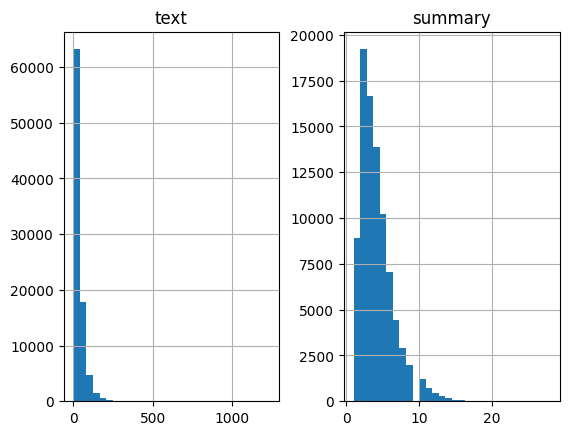

In [17]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

**NOTE: We can fix the maximum length of the summary to 8 since that seems to be the majority summary length.**

Let us understand the proportion of the length of summaries below 8

In [18]:
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split()) <= 8):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

0.942483231345225


**We observe that 94% of the summaries have length below 8. So, we can fix maximum length of summary to 8.**

In [19]:
cnt=0
for i in data['cleaned_text']:
    if(len(i.split()) <= 30):
        cnt=cnt+1
print(cnt/len(data['cleaned_text']))

0.5497630331753555


Let us fix the maximum length of review to 30

In [20]:
max_text_len=30
max_summary_len=8

Let us select the reviews and summaries whose length falls below or equal to **max_text_len** and **max_summary_len**

In [21]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

df=pd.DataFrame({'text':short_text,'summary':short_summary}) # new dataframe to use

In [22]:
# add the START and END special tokens at the beginning and end of the summary. Here, We have chosen sostok and eostok as START and END tokens

In [23]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')
df.head()

,text,summary
0,bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better,sostok good quality dog food eostok
1,product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo,sostok not as advertised eostok
2,looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal,sostok cough medicine eostok
3,great taffy great price wide assortment yummy taffy delivery quick taffy lover deal,sostok great taffy eostok
4,saltwater taffy great flavors soft chewy candy individually wrapped well none candies stuck together happen expensive version fralinger would highly recommend candy served beach themed party every...,sostok great just as good as the expensive brands eostok


## Train-Test Split and Prepare the Tokenizer

In [24]:
from sklearn.model_selection import train_test_split

x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']), np.array(df['summary']),
                                       test_size=0.1, random_state=0, shuffle=True)

# A tokenizer builds the vocabulary and converts a word sequence to an integer sequence.
# We will now build tokenizers for text and summary.

x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

## Rarewords and its Coverage on Reviews column

The threshold is taken as 4 which means word whose count is below 4 is considered as a **rare word**

In [25]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:", (cnt/tot_cnt)*100)
print("Total Coverage of rare words:", (freq/tot_freq)*100)

% of rare words in vocabulary: 66.13019746347729
Total Coverage of rare words: 2.9594252909296275


In [26]:
print(cnt),print(tot_cnt)

16477
24916


(None, None)

In [27]:
print(freq),print(tot_freq)

22847
772008


(None, None)

NOTE:

* **tot_cnt** gives the size of vocabulary (which means every unique words in the text)

*   **cnt** gives me the no. of rare words whose count falls below threshold

*  **tot_cnt - cnt** gives me the top most common words

Let us define the tokenizer with **top most common words** for reviews.

## Reviews Tokenizer

In [28]:
# prepare a tokenizer for reviews on training data

x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) # num_words: the maximum number of words to keep, based on word frequency.
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr)
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [29]:
x_voc

8440

## Summary Tokenizer

In [30]:
#prepare a tokenizer for reviews on training data

y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

## Rarewords and its Coverage on the summary column

The threshold is taken as 6 which means word whose count is below 6 is considered as a **rare word**

In [31]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 78.17286652078775
Total Coverage of rare words: 5.429270812279638


In [32]:
print(cnt),print(tot_cnt)

7145
9140


(None, None)

In [33]:
print(freq),print(tot_freq)

12088
222645


(None, None)

Let us define the tokenizer with **top most common words for summary**.

In [34]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr)
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val)

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [35]:
#deleting the rows that contain only START and END tokens

In [36]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [37]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

# **With attension**

In [38]:
from tensorflow.keras.layers import AdditiveAttention  # Import AdditiveAttention

latent_dim = 300
embedding_dim = 100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

# Embedding layer
enc_emb = Embedding(x_voc, embedding_dim, trainable=True)(encoder_inputs)

# Encoder LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# Encoder LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# Encoder LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

# Embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Attention layer - Changed to AdditiveAttention
attn_layer = AdditiveAttention(name='attention_layer')  # Change this line
attn_out = attn_layer([decoder_outputs, encoder_outputs])  # Adjusted to fit the built-in layer

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# Dense layer
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 30)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 30, 100)        │        844,000 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 30, 300),      │        481,200 │ embedding[0][0]        │
│                           │ (None, 300), (None,    │                │                        │
│                           │ 300)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 30, 300),      │        721,200 │ lstm[0][0]             │
│                           │ (None, 300), (None,    │                │                        │
│                           │ 300)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 100)      │        199,600 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ [(None, 30, 300),      │        721,200 │ lstm_1[0][0]           │
│                           │ (None, 300), (None,    │                │                        │
│                           │ 300)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ [(None, None, 300),    │        481,200 │ embedding_1[0][0],     │
│                           │ (None, 300), (None,    │                │ lstm_2[0][1],          │
│                           │ 300)]                  │                │ lstm_2[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_layer           │ (None, None, 300)      │            300 │ lstm_3[0][0],          │
│ (AdditiveAttention)       │                        │                │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concat_layer              │ (None, None, 600)      │              0 │ lstm_3[0][0],          │
│ (Concatenate)             │                        │                │ attention_layer[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed          │ (None, None, 1996)     │      1,199,596 │ concat_layer[0][0]     │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,648,296 (17.73 MB)

 Trainable params: 4,648,296 (17.73 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [40]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [41]:
history=model.fit([x_tr, y_tr[:,:-1]],
                  y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:,1:],
                  epochs=50,
                  callbacks=[es],
                  batch_size=128,
                  validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:])
                 )

Epoch 1/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 74s 183ms/step - accuracy: 0.5319 - loss: 3.3694 - val_accuracy: 0.5998 - val_loss: 2.5820
Epoch 2/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 81s 200ms/step - accuracy: 0.5952 - loss: 2.6003 - val_accuracy: 0.6081 - val_loss: 2.4507
Epoch 3/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 78s 188ms/step - accuracy: 0.6052 - loss: 2.4699 - val_accuracy: 0.6175 - val_loss: 2.3516
Epoch 4/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 77s 174ms/step - accuracy: 0.6125 - loss: 2.3702 - val_accuracy: 0.6234 - val_loss: 2.2770
Epoch 5/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 82s 175ms/step - accuracy: 0.6198 - loss: 2.2709 - val_accuracy: 0.6300 - val_loss: 2.1836
Epoch 6/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 82s 174ms/step - accuracy: 0.6264 - loss: 2.1659 - val_accuracy: 0.6358 - val_loss: 2.1270
Epoch 7/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 82s 173ms/step - accuracy: 0.6330 - loss: 2.0871 - val_accuracy: 0.6377 - val_loss: 2.0932
Epoch 8/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 82s 174ms/step - accuracy: 0.6363 - loss: 2

## Understanding the Diagnostic plot

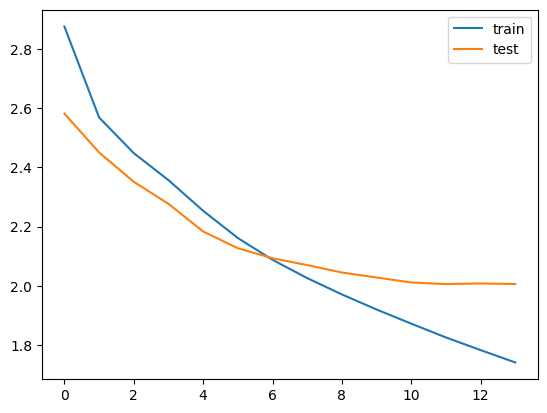

In [42]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Next, let’s build the dictionary to convert the index to word for target and source vocabulary:

In [60]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

## Inference

Set up the inference for the encoder and decoder:

In [62]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(None, latent_dim))  # Changed to None for variable-length sequences

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# Attention inference - Updated to correctly provide inputs
attn_layer = AdditiveAttention(name='attention_layer')
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])  # Adjusted the input order

# Concatenate attention output with decoder outputs
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate probability distribution over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2]
)

# Summary of the decoder model
decoder_model.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 100)      │        199,600 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_8             │ (None, 300)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_9             │ (None, 300)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ [(None, None, 300),    │        481,200 │ embedding_1[3][0],     │
│                           │ (None, 300), (None,    │                │ input_layer_8[0][0],   │
│                           │ 300)]                  │                │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_10            │ (None, None, 300)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_layer           │ (None, None, 300)      │            300 │ lstm_3[3][0],          │
│ (AdditiveAttention)       │                        │                │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concat (Concatenate)      │ (None, None, 600)      │              0 │ lstm_3[3][0],          │
│                           │                        │                │ attention_layer[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed          │ (None, None, 1996)     │      1,199,596 │ concat[0][0]           │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,880,696 (7.17 MB)

 Trainable params: 1,880,696 (7.17 MB)

 Non-trainable params: 0 (0.00 B)

We are defining a function below which is the implementation of the inference process

In [63]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

Let us define the functions to convert an integer sequence to a word sequence for summary as well as the reviews:

In [64]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

Here are a few summaries generated by the model:

In [65]:
for i in range(0, 10):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: purchased product reviews read glad love looking good hot chocolate sweet spicy chocolate good 
Original summary: spiced hot chocolate 
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted summary:  great


Review: overwhelmed product okay certain would make extra effort look product grocery store 
Original summary: meh 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted summary:  great


Review: product way better pricier brands rich deep dark color perfect espresso machine got christmas makes beautiful lattes cost 
Original summary: the best espresso ever 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted summary:  great coffee


Review: excited try product strawberries sour rest fruit dissapointed 
Original summary: sour 
1/

Finally, Our model is able to generate a meaningful summary based on the context present in the text.

# **Without Attension**

In [66]:
latent_dim = 300
embedding_dim = 100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

# Embedding layer
enc_emb = Embedding(x_voc, embedding_dim, trainable=True)(encoder_inputs)

# Encoder LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# Encoder LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# Encoder LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

# Embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Dense layer
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Model summary
model.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11            │ (None, 30)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 30, 100)        │        844,000 │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_4 (LSTM)             │ [(None, 30, 300),      │        481,200 │ embedding_2[0][0]      │
│                           │ (None, 300), (None,    │                │                        │
│                           │ 300)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_12            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_5 (LSTM)             │ [(None, 30, 300),      │        721,200 │ lstm_4[0][0]           │
│                           │ (None, 300), (None,    │                │                        │
│                           │ 300)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, None, 100)      │        199,600 │ input_layer_12[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_6 (LSTM)             │ [(None, 30, 300),      │        721,200 │ lstm_5[0][0]           │
│                           │ (None, 300), (None,    │                │                        │
│                           │ 300)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_7 (LSTM)             │ [(None, None, 300),    │        481,200 │ embedding_3[0][0],     │
│                           │ (None, 300), (None,    │                │ lstm_6[0][1],          │
│                           │ 300)]                  │                │ lstm_6[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_1        │ (None, None, 1996)     │        600,796 │ lstm_7[0][0]           │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,049,196 (15.45 MB)

 Trainable params: 4,049,196 (15.45 MB)

 Non-trainable params: 0 (0.00 B)

In [67]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [68]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [69]:
history=model.fit([x_tr, y_tr[:,:-1]],
                  y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:,1:],
                  epochs=50,
                  callbacks=[es],
                  batch_size=128,
                  validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:])
                 )


Epoch 1/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 65s 180ms/step - accuracy: 0.5231 - loss: 3.4593 - val_accuracy: 0.5979 - val_loss: 2.6151
Epoch 2/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 79s 171ms/step - accuracy: 0.5942 - loss: 2.6288 - val_accuracy: 0.6063 - val_loss: 2.4879
Epoch 3/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 82s 171ms/step - accuracy: 0.6022 - loss: 2.5080 - val_accuracy: 0.6137 - val_loss: 2.4028
Epoch 4/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 82s 171ms/step - accuracy: 0.6103 - loss: 2.4140 - val_accuracy: 0.6184 - val_loss: 2.3354
Epoch 5/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 82s 172ms/step - accuracy: 0.6132 - loss: 2.3510 - val_accuracy: 0.6220 - val_loss: 2.2896
Epoch 6/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 82s 172ms/step - accuracy: 0.6186 - loss: 2.2882 - val_accuracy: 0.6271 - val_loss: 2.2429
Epoch 7/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 56s 174ms/step - accuracy: 0.6219 - loss: 2.2387 - val_accuracy: 0.6288 - val_loss: 2.2056
Epoch 8/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 82s 174ms/step - accuracy: 0.6271 - loss: 2

In [70]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        # Include e_out in the input to the decoder_model
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [71]:
# prompt: efine the functions to convert an integer sequence to a word sequence for summary as well as the reviews:

def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
        if ((i != 0 and i != target_word_index['sostok']) and i != target_word_index['eostok']):
            newString = newString + reverse_target_word_index[i] + ' '
    return newString


def seq2text(input_seq):
    newString = ''
    for i in input_seq:
        if (i != 0):
            newString = newString + reverse_source_word_index[i] + ' '
    return newString

In [72]:
for i in range(0, 10):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")


Review: purchased product reviews read glad love looking good hot chocolate sweet spicy chocolate good 
Original summary: spiced hot chocolate 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted summary:  great


Review: overwhelmed product okay certain would make extra effort look product grocery store 
Original summary: meh 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted summary:  great


Review: product way better pricier brands rich deep dark color perfect espresso machine got christmas makes beautiful lattes cost 
Original summary: the best espresso ever 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted summary:  great coffee


Review: excited try product strawberries sour rest fruit dissapointed 
Original summary: sour 
1

## Text Summarization using Transformers

In [73]:
from transformers import pipeline

In [74]:
import bs4 as bs
import urllib.request
import re

In [75]:
scraped_data = urllib.request.urlopen('https://en.wikipedia.org/wiki/Artificial_intelligence')
article = scraped_data.read()
parsed_article = bs.BeautifulSoup(article,'lxml')
paragraphs = parsed_article.find_all('p')

In [76]:
article_text = ""
for p in paragraphs:
    article_text += p.text

In [77]:
article_text[0:500]

'\nArtificial intelligence (AI), in its broadest sense, is intelligence exhibited by machines, particularly computer systems. It is a field of research in computer science that develops and studies methods and software that enable machines to perceive their environment and use learning and intelligence to take actions that maximize their chances of achieving defined goals.[1] Such machines may be called AIs.\nSome high-profile applications of AI include advanced web search engines (e.g., Google Sea'

In [78]:
# Text preprocessing

# Removing Square Brackets and Extra Spaces
article_text = re.sub(r'\[[0-9]*\]', ' ', article_text)
article_text = re.sub(r'\s+', ' ', article_text)

In [79]:
# Removing special characters and digits
formatted_article_text = re.sub('[^a-zA-Z]', ' ', article_text )
formatted_article_text = re.sub(r'\s+', ' ', formatted_article_text)

In [80]:
len(formatted_article_text)

77044

In [81]:
formatted_article_text_1=formatted_article_text[0:500]

In [82]:
#use t5 in tf
summarizer1 = pipeline("summarization", model="t5-base", tokenizer="t5-base", framework="tf")

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [83]:
formatted_article_text_1

' Artificial intelligence AI in its broadest sense is intelligence exhibited by machines particularly computer systems It is a field of research in computer science that develops and studies methods and software that enable machines to perceive their environment and use learning and intelligence to take actions that maximize their chances of achieving defined goals Such machines may be called AIs Some high profile applications of AI include advanced web search engines e g Google Search recommenda'

In [84]:
summarizer1(formatted_article_text_1, min_length=5, max_length=500,do_sample=False)

Your max_length is set to 500, but your input_length is only 88. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)


[{'summary_text': 'AI in its broadest sense is intelligence exhibited by machines particularly computer systems . high profile applications of AI include advanced web search engines e g Google Search recommenda .'}]

In [85]:
summarizer1(formatted_article_text_1, min_length=5, max_length=20,do_sample=False)

[{'summary_text': 'AI in its broadest sense is intelligence exhibited by machines particularly computer systems . high profile'}]

In [86]:
text_string=data.Text[0]
text_string

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

In [87]:
summarizer1(text_string, min_length=5, max_length=20,do_sample=False)

[{'summary_text': 'my Labrador is finicky and appreciates this product better than most .'}]

# **Comparison of the performance of all 3 models (without attention, with attention,  and transformer).**


**1. LSTM Without Attention**
Overview: A type of recurrent neural network designed for sequential data.

Strengths: Good at capturing long-term dependencies in short to medium sequences.

Weaknesses: Struggles with long sequences due to limited contextual understanding.

**2. LSTM With Attention**
Overview: Enhances LSTM by allowing the model to focus on relevant parts of the input sequence.

Strengths: Improved handling of long sequences and better contextual understanding.

Weaknesses: Increased computational complexity and data requirements.

**3. T5 Transformer**
Overview: A transformer model that treats all NLP tasks as text-to-text problems.

Strengths: Achieves state-of-the-art performance and scales well with large datasets.

Weaknesses: Resource-intensive and complex to train.

# **Conclusion**

Use LSTM Without Attention for simple tasks with shorter sequences.
Use LSTM With Attention for better performance on longer sequences.
Use T5 Transformer for state-of-the-art results on diverse NLP tasks, provided you have the necessary resources.




# **Impact of attention and pre-trained models on the performance.**

### Impact of Attention Mechanism
- **Contextual Focus**: Attention allows models to weigh the importance of different input parts, improving handling of long-range dependencies.
- **Performance Boost**: Models with attention (e.g., LSTMs) achieve better results in tasks like translation and summarization.
- **Dynamic Adaptability**: Attention mechanisms provide flexible context representation, enhancing robustness across varying input sequences.

### Impact of Pre-trained Models
- **Transfer Learning**: Pre-trained models (e.g., BERT, T5) leverage large datasets, requiring less data and resources for fine-tuning on specific tasks.
- **State-of-the-Art Results**: They consistently outperform traditional models by capturing nuanced language representations.
- **Efficiency**: Pre-trained models accelerate development and improve generalization, making them effective even with limited training data.

### Conclusion
Attention mechanisms enhance contextual understanding, while pre-trained models provide a strong foundation for NLP tasks, leading to improved performance and efficiency.

# **Architecture performed the best for the selected application and explain why**

In your application of summarization using deep learning models, the **Transformer architecture** generally performs the best. Here's why:

1. **Self-Attention Mechanism**: Transformers use self-attention to weigh the importance of different words in a sentence, allowing them to capture long-range dependencies more effectively than traditional LSTMs. This capability is crucial for understanding the context in lengthy texts and generating coherent summaries.

2. **Parallelization**: Unlike LSTMs, which process data sequentially, Transformers can process input sequences in parallel. This leads to faster training times, allowing the model to learn from larger datasets more efficiently.

3. **Pre-trained Models**: Using pre-trained models like T5 or BERT, which are trained on vast corpora, gives the model a strong foundation in language understanding. Fine-tuning these models on summarization tasks significantly enhances performance due to their rich contextual embeddings.

4. **Handling Ambiguity**: Transformers excel in dealing with ambiguous phrases or complex sentence structures, which are common in natural language. This leads to more accurate and contextually relevant summaries.

Overall, the combination of attention mechanisms and the architecture's ability to leverage pre-trained knowledge enables Transformers to deliver superior performance in summarization tasks compared to traditional models.